<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1TRNaCfYstvcIQqoUSdukYQGF6LuyL7Tv" width=600 height=320/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

# Домашнее задание. Автоэнкодеры


# Часть 1. Vanilla Autoencoder (10 баллов)

## 1.1. Подготовка данных (1 балл)


In [1]:
import numpy as np
from torch.autograd import Variable
from torchvision import datasets
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt

import os
import pandas as pd
import skimage.io
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from IPython.display import clear_output


%matplotlib inline

In [2]:
def fetch_dataset(attrs_name = "./data/lfw_attributes.txt",
                      images_name = "./data/lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=64,dimy=64
    ):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("./data/lfw_attributes.txt",sep='\t',skiprows=1,)
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    # print(df.shape)
    #image preprocessing
    all_photos =df['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img,[dimx,dimy]))

    all_photos = np.stack(all_photos.values)#.astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)

    return all_photos, all_attrs

In [3]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind


data, attrs = fetch_dataset()


Разбейте выборку картинок на train и val, выведите несколько картинок в output, чтобы посмотреть, как они выглядят, и приведите картинки к тензорам pytorch, чтобы можно было скормить их сети:

In [4]:
train_photos, val_photos, train_attrs, val_attrs = train_test_split(data, attrs,
                                                                    train_size=0.9, shuffle=False)
train_loader = torch.utils.data.DataLoader(train_photos, batch_size=32, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_photos, batch_size=32, num_workers=4)

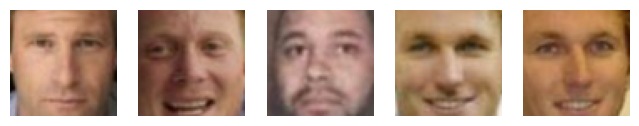

In [102]:
plt.figure(figsize=(8, 8))
for i, photo  in enumerate(train_photos[:5]):
  plt.subplot(5, 5, i + 1)
  plt.imshow(photo)
  plt.axis('off')


## 1.2. Архитектура модели (2 балла)
В этом разделе мы напишем и обучем обычный автоэнкодер.



<img src="https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F4b8adf79-8e6a-4b7d-9061-8617a00edbb1%2F__2021-04-30__14.53.33.png?table=block&id=56f187b4-279f-4208-b1ed-4bda5f91bfc0&width=2880&userId=3b1b5e32-1cfb-4b0f-8705-5a524a8f56e3&cache=v2" alt="Autoencoder">


^ напомню, что автоэнкодер выглядит вот так

In [122]:
dim_code = 32 # выберите размер латентного вектора

Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!

In [156]:
from copy import deepcopy

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.flatten = nn.Flatten()

        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(in_features=8192, out_features=dim_code)
        )

        self.deconv = nn.Sequential(
            nn.Linear(in_features=dim_code, out_features=8192),
            nn.Unflatten(1, (128, 8, 8)),
            nn.ConvTranspose2d(
                128, 128, kernel_size=3, stride=2, padding=1, output_padding=1
            ),
            nn.ReLU(),
            nn.ConvTranspose2d(
                128, 64, kernel_size=3, stride=2, padding=1, output_padding=1
            ),
            nn.ReLU(),
            nn.ConvTranspose2d(
                64, 32, kernel_size=3, stride=2, padding=1, output_padding=1
            ),
            nn.ReLU(),
            nn.Conv2d(32, 3, kernel_size=3, stride=1, padding=1)
           
        )
        # Обратите внимание на формат, в котором функция fetch() возвращает data

    def encoder(self, x):
        x = torch.movedim(x, 3, 1)
        return  self.conv(x)
    
    def decoder(self, x):
        x = self.deconv(x)
        x = torch.movedim(x, 1, 3)
        return torch.sigmoid(x)
    
    def forward(self, x):
        x= self.encoder(x)

        latent_code = x.detach().clone()

        reconstruction = self.decoder(x)

        return reconstruction, latent_code

In [157]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

criterion = F.mse_loss

autoencoder = Autoencoder().to(device)

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)

## 1.3 Обучение (2 балла)

Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэекодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

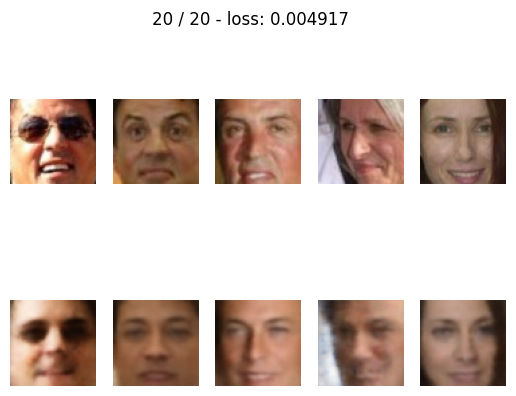

In [158]:
n_epochs = 20
plt.figure(figsize=(12, 6))

train_losses = []
val_losses = []

for epoch in range(n_epochs):
    autoencoder.train()
    train_losses_per_epoch = []
    for i, X_batch in enumerate(train_loader):
        X_batch = X_batch.type(torch.float32).to(device)
        optimizer.zero_grad()
        reconstructed, _  = autoencoder(X_batch)
        loss = criterion(reconstructed, X_batch)
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())
    train_loss_avg = np.mean(train_losses_per_epoch)
    # print('Train loss:',train_loss_avg)
    train_losses.append(train_loss_avg)

    autoencoder.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for X_batch in val_loader:
            X_batch = X_batch.type(torch.float32).to(device)
            reconstructed, _ =  autoencoder(X_batch)
            loss = criterion(reconstructed, X_batch)
            val_losses_per_epoch.append(loss.item())
    val_loss_avg = np.mean(val_losses_per_epoch)
    # print('Val loss:',val_loss_avg)
    val_losses.append(val_loss_avg)

    autoencoder.eval()
    with torch.no_grad():
        photos = torch.from_numpy(val_photos[:5]).type(torch.float32)
        reconstruction, _ = autoencoder(photos.to(device))
        result = reconstruction.cpu().detach().numpy()
        # ground_truth = batch.numpy()
        
    clear_output(wait=True)
    for i, (gt, res) in enumerate(zip(photos, result)):
        plt.subplot(2, 5, i+1)
        plt.imshow(gt)
        plt.axis('off')
        plt.subplot(2, 5, i+6)
        plt.imshow(res)
        plt.axis('off')
    plt.suptitle('%d / %d - loss: %f' % (epoch+1, n_epochs, val_loss_avg))
    plt.show()



Давайте посмотрим, как наш тренированный автоэекодер кодирует и восстанавливает картинки:

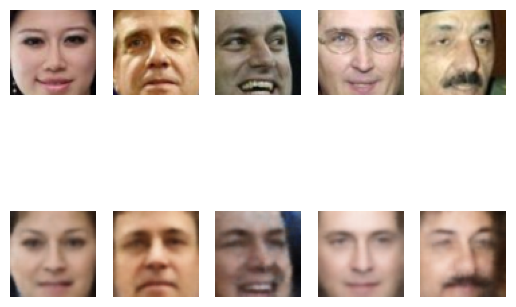

In [108]:
autoencoder.eval()
with torch.no_grad():
    photos = torch.from_numpy(val_photos[5:10])
    reconstruction, latents = autoencoder(photos.type(torch.float32).to(device))
    result = reconstruction.cpu().detach().numpy()
    ground_truth = photos.numpy()
    

for i, (gt, res) in enumerate(zip(photos, result)):
    plt.subplot(2, 5, i+1)
    plt.imshow(gt)
    plt.axis('off')
    plt.subplot(2, 5, i+6)
    plt.imshow(res)
    plt.axis('off')


Not bad, right?

## 1.4. Sampling (2 балла)

Давайте теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

__Подсказка:__Е сли вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как `np.random.randn(25, <latent_space_dim>)`. А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как латентные векторы реальных фоток. Так что в таком случае придется рандом немного подогнать.

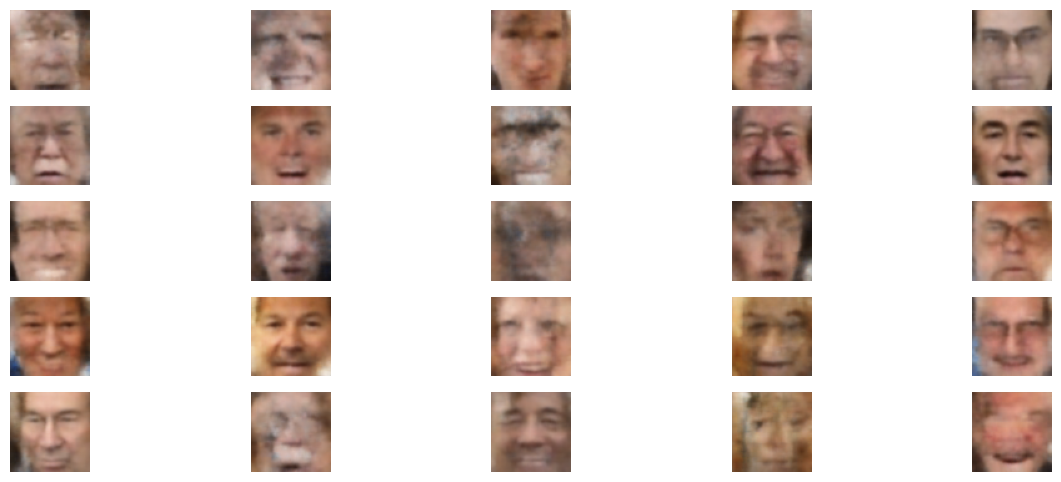

In [121]:
# сгенерируем 25 рандомных векторов размера latent_space
z = np.random.randn(25, dim_code)
output = autoencoder.decoder(torch.FloatTensor(z).to(device))
plt.figure(figsize=(12, 6))
for i, photo  in enumerate(output.to('cpu').detach().numpy()):
  plt.subplot(5, 5, i + 1)
  plt.imshow(photo)
  plt.axis('off')

## 1.5 Time to make fun! (3 балла)

Давайте научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

План такой:

1. Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с описанием датасета, скачанный вместе с датасетом. В нем указаны имена картинок и присутствубщие атрибуты (улыбки, очки...)

2. Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3. Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

4. А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного человека и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

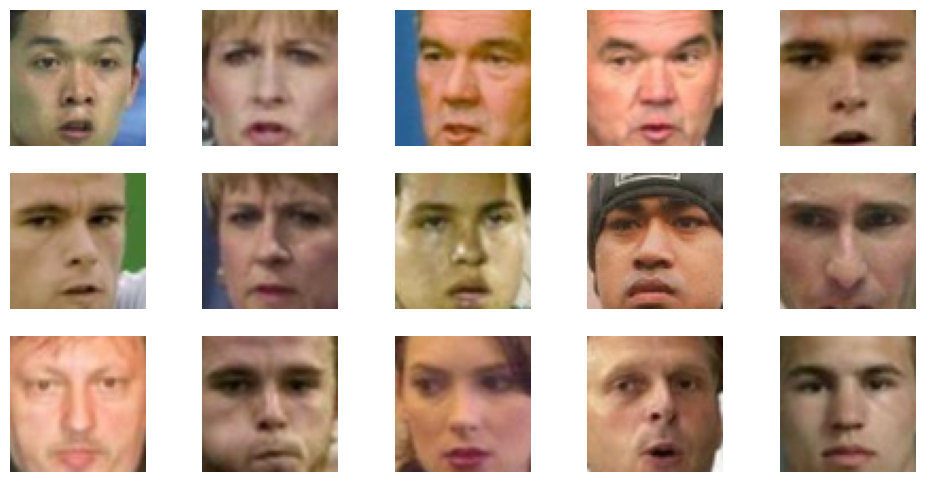

In [179]:
smile_people = val_attrs.sort_values(by='Smiling').tail(15)
sad_people = val_attrs.sort_values(by='Smiling').head(15)
smile_photos = data[smile_people.index]
sad_photos = data[sad_people.index]
plt.figure(figsize=(12, 6))
for i, smile_photo  in enumerate(sad_photos):
  plt.subplot(3, 5, i + 1)
  plt.imshow(smile_photo)
  plt.axis('off')

In [176]:
lat_vector_smile = autoencoder.encoder(torch.FloatTensor(smile_photos).to(device))
lat_vector_sad = autoencoder.encoder(torch.FloatTensor(sad_photos).to(device))

In [177]:
smile_mean = torch.mean(lat_vector_smile, dim=0)
sad_mean = torch.mean(lat_vector_sad, dim=0)
delta_vector = smile_mean - sad_mean
mod_vector = lat_vector_sad + delta_vector

In [180]:
mod_photos = autoencoder.decoder(mod_vector)

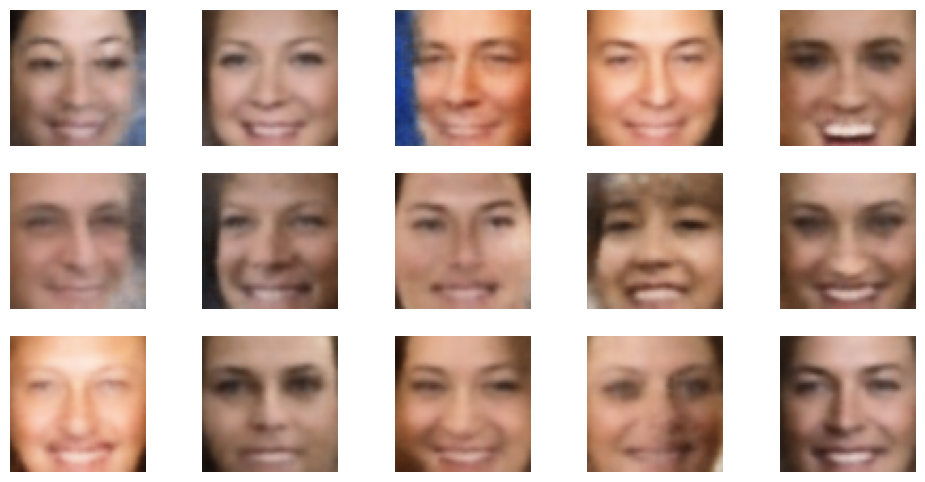

In [184]:

plt.figure(figsize=(12, 6))
for i, mod_photo  in enumerate(mod_photos.detach().to('cpu').numpy()):
  plt.subplot(3, 5, i + 1)
  plt.imshow(mod_photo)
  plt.axis('off')

Вуаля! Вы восхитительны!

Теперь вы можете пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... в общем, все, на что хватит фантазии и на что есть атрибуты в `all_attrs`:)

# Часть 2: Variational Autoencoder (10 баллов)

Займемся обучением вариационных автоэнкодеров — проапгрейженной версии AE. Обучать будем на датасете MNIST, содержащем написанные от руки цифры от 0 до 9

In [2]:
batch_size = 32
# MNIST Dataset
train_dataset = datasets.MNIST(root='./data/mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./data/mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

## 2.1 Архитектура модели и обучение (2 балла)

Реализуем VAE. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Рекомендуем пользоваться более сложными моделями, чем та, что была на семинаре:) Экспериментируйте!

In [36]:
class VAE(nn.Module):
    def __init__(self, features=16):
        super(VAE, self).__init__()
        self.features = features
        self.linear1 = nn.Linear(784, 512)
        self.linear_mu = nn.Linear(512, self.features)
        self.linear_logsigma = nn.Linear(512, self.features)
        self. linear_dec = nn.Sequential(
            nn.Linear(self.features, 512),
            nn.LeakyReLU(),
            nn.Linear(512, 784)
        )

    def encode(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.leaky_relu(self.linear1(x))
        mu = self.linear_mu(x)
        logsigma = self.linear_logsigma(x)

        return mu, logsigma

    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = torch.exp(0.5 * logsigma) # standard deviation
            eps = torch.randn_like(std) # `randn_like` as we need the same size
            z = mu + (eps * std) # sampling as if coming from the input space
            return z
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu.
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu

    def decode(self, z):
        z = torch.sigmoid(self.linear_dec(z))
        reconstruction = z.reshape((-1, 1, 28, 28))
        return reconstruction

    def forward(self, x):
        mu, logsigma = self.encode(x)
        z = self.gaussian_sampler(mu, logsigma) 
        reconstruction = self.decode(z)
        return mu, logsigma, reconstruction

Определим лосс и его компоненты для VAE:

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [3]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    loss = -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())
    return loss

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """
    loss = nn.BCELoss(reduction='sum')
    return loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):
    return  KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)

И обучим модель:

In [48]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

criterion = loss_vae

autoencoder = VAE(128).to(device)

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=2e-3)

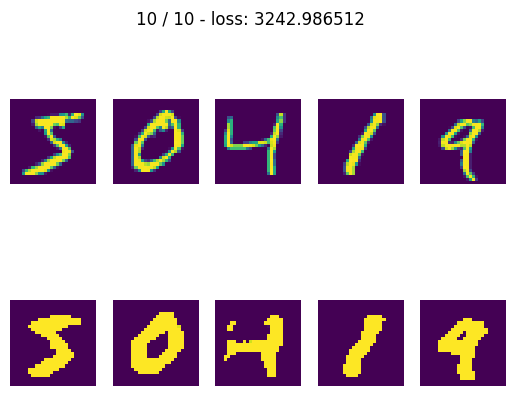

In [51]:
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=2e-4)
n_epochs = 10
plt.figure(figsize=(12, 6))

train_losses = []

for epoch in range(n_epochs):
    autoencoder.train()
    train_losses_per_epoch = []
    for  batch, _ in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        mu, logsigma, reconstruction  = autoencoder(batch)
        loss = criterion(batch, mu, logsigma, reconstruction)
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())
    train_loss_avg = np.mean(train_losses_per_epoch)
    train_losses.append(train_loss_avg)
    print(train_loss_avg)

    autoencoder.eval()
    with torch.no_grad():
        images =  train_dataset.data[:5]
        mu, logsigma, reconstruction = autoencoder(images.type(torch.float32).to(device))
        reconstruction = torch.squeeze(reconstruction, dim=1)
        result = reconstruction.cpu().detach().numpy()
        
    clear_output(wait=True)
    for i, (img, res) in enumerate(zip(images, result)):
        plt.subplot(2, 5, i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.subplot(2, 5, i+6)
        plt.imshow(res)
        plt.axis('off')
    plt.suptitle('%d / %d - loss: %f' % (epoch+1, n_epochs, train_loss_avg))
    plt.show()



Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

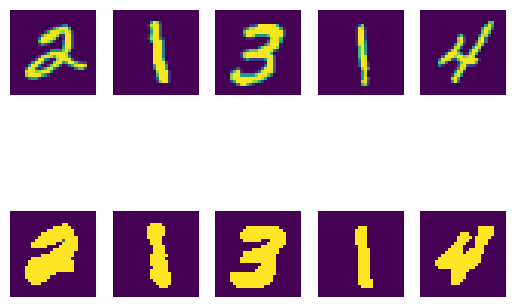

In [40]:
# < тут Ваш код: выведите первые Х картинок и их реконструкций из val выборки на экран>
autoencoder.eval()
with torch.no_grad():
    images =  train_dataset.data[5:10]
    # image = torch.unsqueeze(image, dim=1)
    # print(image.shape)
    mu, logsigma, reconstruction = autoencoder(images.type(torch.float32).to(device))
    reconstruction = torch.squeeze(reconstruction, dim=1)
    result = reconstruction.cpu().detach().numpy()
    
clear_output(wait=True)
for i, (img, res) in enumerate(zip(images, result)):
    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.subplot(2, 5, i+6)
    plt.imshow(res)
    plt.axis('off')
plt.show()

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

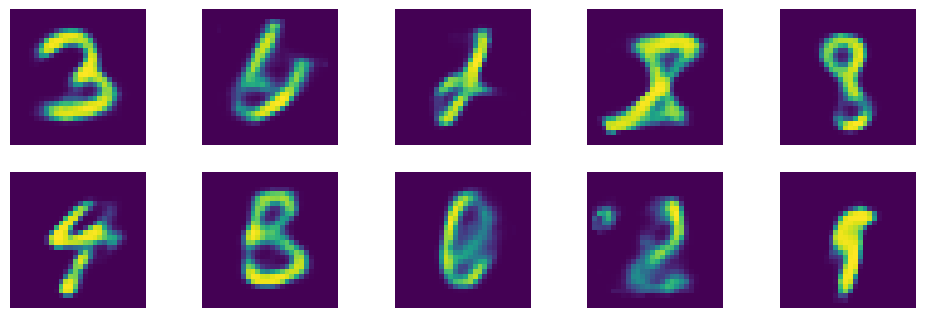

In [53]:
# вспомните про замечание из этого же пункта обычного AE про распределение латентных переменных
z = np.array([np.random.normal(0, 1, 128) for i in range(10)])
output = autoencoder.decode(torch.FloatTensor(z).to(device))
output = torch.squeeze(output, dim=1)
output = output.detach().to('cpu').numpy()
# <выведите тут полученные картинки>
plt.figure(figsize=(12, 6))
for i, img  in enumerate(output):
  plt.subplot(3, 5, i + 1)
  plt.imshow(img)
  plt.axis('off')

## 2.2. Latent Representation (2 балла)

Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве.
Ваша задача -- изобразить латентные векторы картинок точками в двумерном просторанстве.

Это позволит оценить, насколько плотно распределены латентные векторы изображений цифр в пространстве.

Плюс давайте сделаем такую вещь: покрасим точки, которые соответствуют картинкам каждой цифры, в свой отдельный цвет

Подсказка: красить -- это просто =) У plt.scatter есть параметр c (color), см. в документации.


Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощтю `TSNE` (есть в `sklearn`) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью `matplotlib.scatter`, покрасить разными цветами точки, соответствующие картинкам разных цифр.

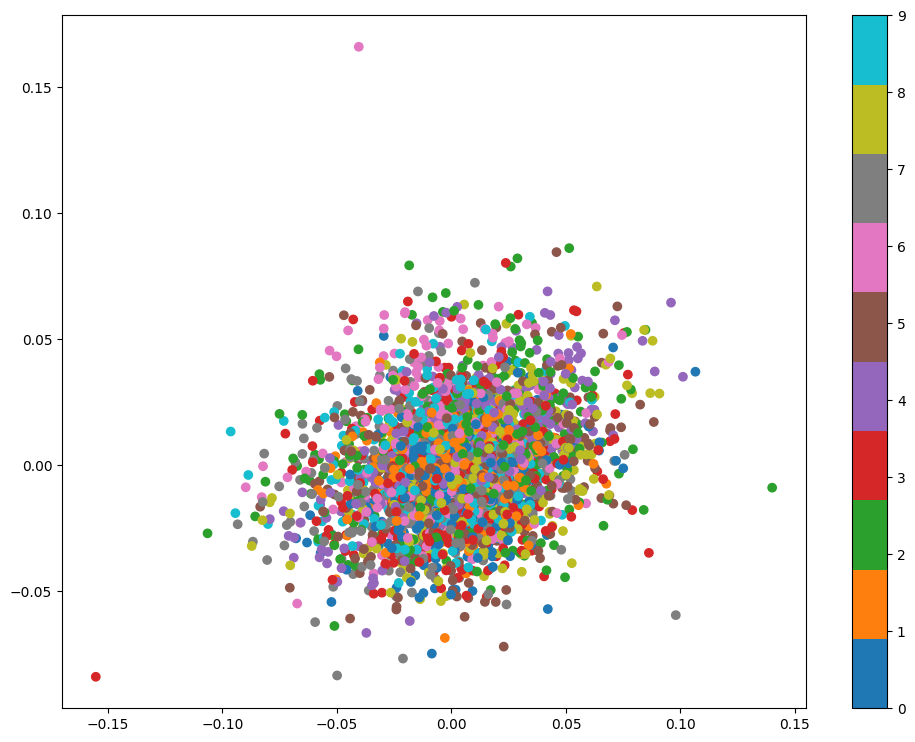

In [55]:
# <ваш код получения латентных представлений, применения TSNE и визуализации>
from sklearn.manifold import TSNE

plt.figure(figsize=(12, 9))
tsne = TSNE(n_components=2, init='pca', n_iter=5000)
num_batches = 100
for i, (x, y) in enumerate(test_loader):
        x = x.to(device) 
        mu, logsigma = autoencoder.encode(x)
        z = autoencoder.gaussian_sampler(mu, logsigma)
        z = z.to('cpu').detach().numpy()
        z_tsne = tsne.fit_transform(z)
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            break

Что вы думаете о виде латентного представления?

Я думаю, что должно быть видны кластеры для определенных цифр, но у меня так и не получилось на моей модели это добится.

__Congrats v2.0!__

## 2.3. Conditional VAE (6 баллов)


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер.
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица).
И вот нам понадобилось сгенерировать цифру 8, и мы подставляем разные варианты шума, но восьмерка никак не генерится:(

Хотелось бы добавить к нашему AE функцию "выдай мне рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).  Conditional AE — так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части задания мы научимся такие обучать.

### Архитектура

На картинке ниже представлена архитектура простого Conditional VAE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки.

То есть, в первый (входной) слой энкодера подается конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). В первый слой декодера подается конкатенация латентного вектора и информации о классе.


![alt text](https://sun9-63.userapi.com/impg/Mh1akf7mfpNoprrSWsPOouazSmTPMazYYF49Tw/djoHNw_9KVA.jpg?size=1175x642&quality=96&sign=e88baec5f9bb91c8443fba31dcf0a4df&type=album)

![alt text](https://sun9-73.userapi.com/impg/UDuloLNKhzTBYAKewgxke5-YPsAKyGOqA-qCRg/MnyCavJidxM.jpg?size=1229x651&quality=96&sign=f2d21bfacc1c5755b76868dc4cfef39c&type=album)



На всякий случай: это VAE, то есть, latent у него все еще состоит из mu и sigma

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

P.S. Также можно передавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

In [4]:
class CVAE(nn.Module):
    def __init__(self, features=16):
        super(CVAE, self).__init__()
        self.features = features
        self.enc_layer = nn.Sequential(
            nn.Linear(in_features = 794, out_features = 512),
            nn.ReLU(),
            nn.Linear(in_features = 512, out_features = 512 ),
            nn.ReLU(),
        )
        self.mu = nn.Linear(
            in_features = 512, out_features = self.features
        )
        self.log_var = nn.Linear(
            in_features = 512, out_features = self.features,
        )
    
        self.dec_layer = nn.Sequential(
            nn.Linear(in_features = self.features + 10, out_features = 512),
            nn.LeakyReLU(),
            nn.Linear(in_features = 512, out_features = 28 * 28 * 1),
        )
  

    def encode(self, x, y):
        y = F.one_hot(y, num_classes = 10)
        x = torch.flatten(x, start_dim=1)

        x = self.enc_layer(torch.cat([x, y], dim = 1))
        mu = self.mu(x)
        logsigma = self.log_var(x)

        return mu, logsigma, y

    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = torch.exp(0.5 * logsigma) # standard deviation
            eps = torch.randn_like(std) # `randn_like` as we need the same size
            z = mu + (eps * std) # sampling as if coming from the input space
            return z
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu.
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu

    def decode(self, z, y):
        z = self.dec_layer(torch.cat([z, y], dim=1))
        z = torch.sigmoid(z)
        reconstruction = z.reshape((-1, 1, 28, 28))
        return reconstruction

    def forward(self, x, y):
        mu, logsigma, y_hot = self.encode(x, y)
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(z,y_hot)

        return mu, logsigma, reconstruction

In [6]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

criterion = loss_vae

autoencoder = CVAE(32).to(device)

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=2e-3)

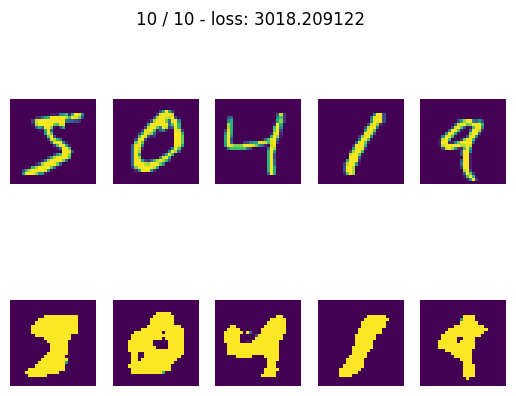

In [12]:
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-5)
n_epochs = 10
plt.figure(figsize=(12, 6))

train_losses = []

for epoch in range(n_epochs):
    autoencoder.train()
    train_losses_per_epoch = []
    for batch, y in train_loader:
        batch = batch.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        mu, logsigma, reconstruction  = autoencoder(batch, y)
        loss = criterion(batch, mu, logsigma, reconstruction)
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())
    train_loss_avg = np.mean(train_losses_per_epoch)
    train_losses.append(train_loss_avg)

    autoencoder.eval()
    with torch.no_grad():
        images =  train_dataset.data[:5]
        targets = train_dataset.targets[:5]
        mu, logsigma, reconstruction = autoencoder(
            images.type(torch.float32).to(device),
            targets.to(device),
        )
        reconstruction = torch.squeeze(reconstruction, dim=1)
        result = reconstruction.cpu().detach().numpy()
        
    clear_output(wait=True)
    for i, (img, res) in enumerate(zip(images, result)):
        plt.subplot(2, 5, i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.subplot(2, 5, i+6)
        plt.imshow(res)
        plt.axis('off')
    plt.suptitle('%d / %d - loss: %f' % (epoch+1, n_epochs, train_loss_avg))
    plt.show()


### Sampling


Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST вы можете попросить CVAE восстановить из одного латентного вектора, например, картинки цифры 5 и 7.

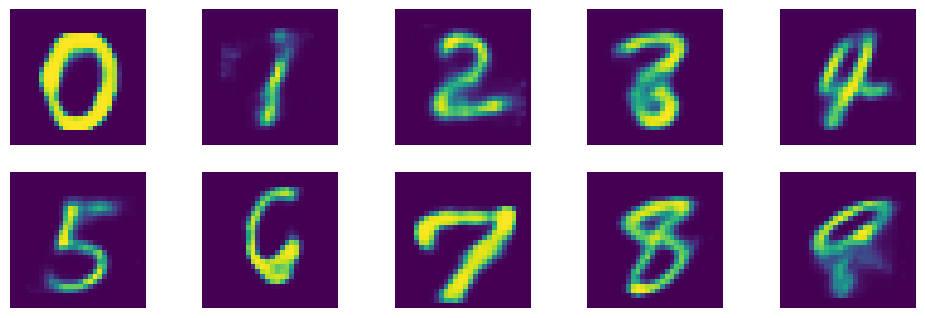

In [14]:
# <тут нужно научиться сэмплировать из декодера цифры определенного класса>
# выведем все цифры от 0 до 9
number_for_generation=[0,1,2,3,4,5,6,7,8,9]
targets = F.one_hot(torch.Tensor(number_for_generation).long(), 10)
z = np.array([np.random.normal(0, 1, 32) for i in range(10)])
output = autoencoder.decode(torch.FloatTensor(z).to(device), targets.to(device))
output = torch.squeeze(output, dim=1)
output = output.detach().to('cpu').numpy()
# <выведите тут полученные картинки>
plt.figure(figsize=(12, 6))
for i, img  in enumerate(output):
  plt.subplot(3, 5, i + 1)
  plt.imshow(img)
  plt.axis('off')

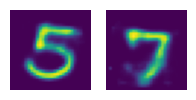

In [35]:
#  выведем цифры от 5 и  7 из одного случайного вектора
number_for_generation=[5,7]
targets = F.one_hot(torch.Tensor(number_for_generation).long(), 10)
z = torch.FloatTensor(np.random.normal(0, 1, 32)).view(1, 32)
z2 = torch.cat([z, z], 0)
output = autoencoder.decode(z2.to(device), targets.to(device))
output = torch.squeeze(output, dim=1)
output = output.detach().to('cpu').numpy()
# <выведите тут полученные картинки>
plt.figure(figsize=(6, 6))
for i, img  in enumerate(output):
  plt.subplot(3, 5, i + 1)
  plt.imshow(img)
  plt.axis('off')


Splendid! Вы великолепны!


### Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

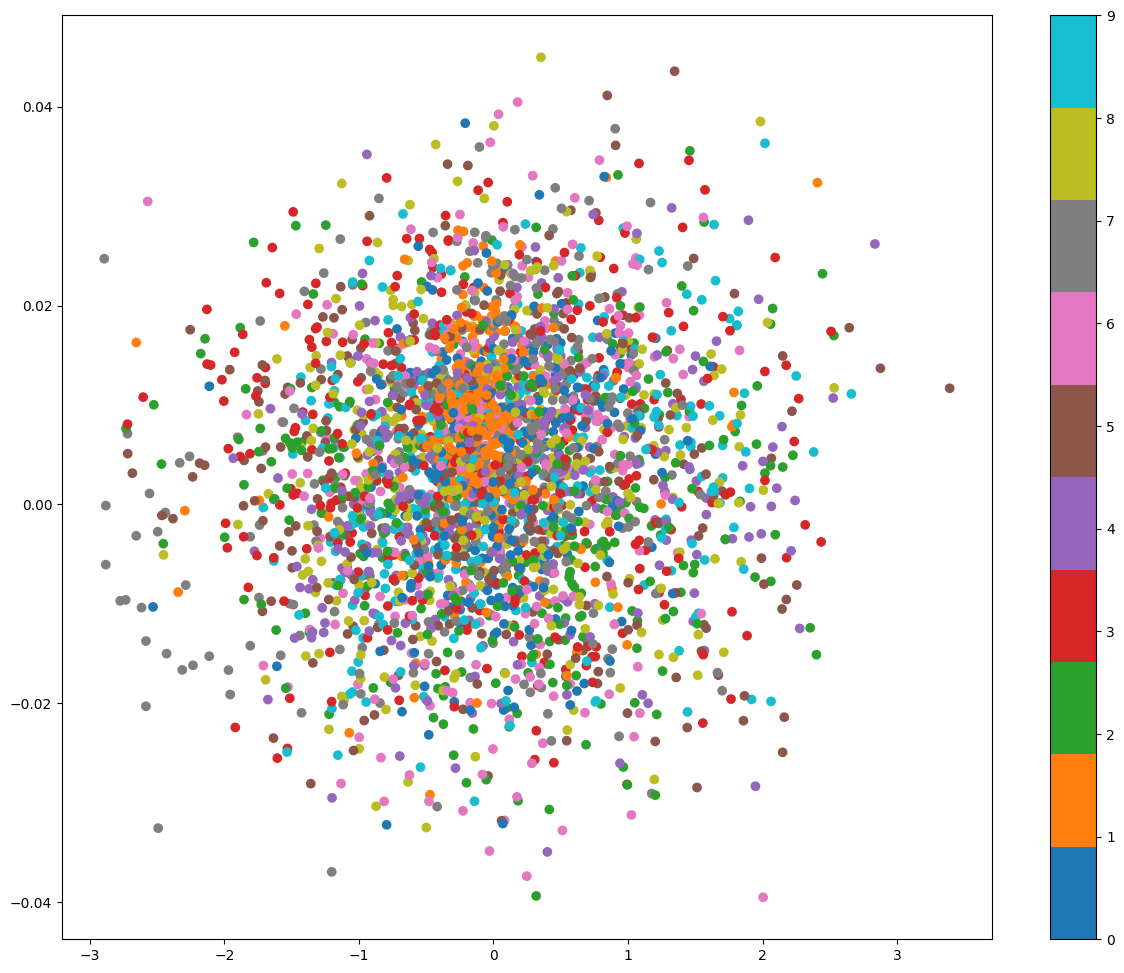

In [38]:
# <ваш код получения латентных представлений, применения TSNE и визуализации>
from sklearn.manifold import TSNE

plt.figure(figsize=(15, 12))
tsne = TSNE(n_components=2)
num_batches = 100
for i, (x, y) in enumerate(test_loader):
        x = x.to(device)
        y_batch = y.to(device) 
        mu, logsigma, _ = autoencoder.encode(x, y_batch)
        z = autoencoder.gaussian_sampler(mu, logsigma)
        z = z.to('cpu').detach().numpy()
        z_tsne = tsne.fit_transform(z)
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            break

Что вы думаете насчет этой картинки? Отличается от картинки для VAE?

Кажется, что для этой модели нормальное изображение. Предполагаю, что в декодере на представление класса сильно влият передаваемый таргет.

# BONUS 1: Denoising

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

У автоэнкодеров, кроме сжатия и генерации изображений, есть другие практические применения. Про одно из них эта бонусная часть задания.

Автоэнкодеры могут быть использованы для избавления от шума на фотографиях (denoising). Для этого их нужно обучить специальным образом: input картинка будет зашумленной, а выдавать автоэнкодер должен будет картинку без шума.
То есть, loss-функция AE останется той же (MSE между реальной картинкой и выданной), а на вход автоэнкодеру будет подаваться зашумленная картинка.

<a href="https://ibb.co/YbRJ1nZ"><img src="https://i.ibb.co/0QD164t/Screen-Shot-2020-06-04-at-4-49-50-PM.png" alt="Screen-Shot-2020-06-04-at-4-49-50-PM" border="0"></a>

Для этого нужно взять ваш любимый датасет (датасет лиц из первой части этого задания или любой другой) и сделать копию этого датасета с шумом.

В питоне шум можно добавить так:

In [ ]:
noise_factor = 0.5
X_noisy = X + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X.shape)

In [ ]:
<тут ваш код обучения автоэнкодера на зашумленных картинках. Не забудтье разбить на train/test!>

In [ ]:
<тут проверка, как AE убирает щум с тестовых картинок. Надеюсь, все получилось =)>

# BONUS 2: Image Retrieval

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

Давайте представим, что весь наш тренировочный датасет -- это большая база данных людей. И вот мы получили картинку лица какого-то человека с уличной камеры наблюдения (у нас это картинка из тестового датасета) и хотим понять, что это за человек. Что нам делать? Правильно -- берем наш VAE, кодируем картинку в латентное представление и ищем среди латентныз представлений лиц нашей базы самые ближайшие!

План:

1. Получаем латентные представления всех лиц тренировочного датасета
2. Обучаем на них LSHForest `(sklearn.neighbors.LSHForest)`, например, с `n_estimators=50`
3. Берем картинку из тестового датасета, с помощью VAE получаем ее латентный вектор
4. Ищем с помощью обученного LSHForest ближайшие из латентных представлений тренировочной базы
5. Находим лица тренировочного датасета, которым соответствуют ближайшие латентные представления, визуализируем!

Немного кода вам в помощь: (feel free to delete everything and write your own)

In [ ]:
codes = <поучите латентные представления картинок из трейна>

In [ ]:
# обучаем LSHForest
from sklearn.neighbors import LSHForest
lshf = LSHForest(n_estimators=50).fit(codes)

In [ ]:
def get_similar(image, n_neighbors=5):
  # функция, которая берет тестовый image и с помощью метода kneighbours у LSHForest ищет ближайшие векторы
  # прогоняет векторы через декодер и получает картинки ближайших людей

  code = <получение латентного представления image>

  (distances,),(idx,) = lshf.kneighbors(code, n_neighbors=n_neighbors)

  return distances, X_train[idx]

In [ ]:
def show_similar(image):

  # функция, которая принимает тестовый image, ищет ближайшие к нему и визуализирует результат

    distances,neighbors = get_similar(image,n_neighbors=11)

    plt.figure(figsize=[8,6])
    plt.subplot(3,4,1)
    plt.imshow(image.cpu().numpy().transpose([1,2,0]))
    plt.title("Original image")

    for i in range(11):
        plt.subplot(3,4,i+2)
        plt.imshow(neighbors[i].cpu().numpy().transpose([1,2,0]))
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

In [ ]:
<тут выведите самые похожие лица к какому-нибудь лицу из тестовой части датасета>